# CSE 676B
### Deep Learning
by `Prof. Alina Vereshchaka`
<br>

## <b>FINAL PROJECT</b>
<br>

<i>TEAM</i>🔻<br>
SOUBHIK SINHA (<b>soubhiks</b>)<br>
AISHWARYA MUTTINENI (<b>amuttine</b>)<br>
EKLAVYA (<b>eklavya</b>)
<br>
<br>

PROJECT TOPIC : <b><i>`BRAIN TUMOUR CLASSIFICATION USING DEEP LEARNING TECHNIQUES BASED ON MRI IMAGES`</i></b>

CHECKPOINT : <b><mark>April 4, 2024</mark></b><br>
FINAL SUBMISSION : <b><mark>May 2, 2024</mark></b>
<br><br>

COMPONENT : <b>`DenseNet`</b>

In [ ]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Let us import the necessary libraries required
# We will later on import more of them - as per requirement

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
'''
In the notebook for VGG13 implementation, we were already done with the
following :
- Data Extraction
- Data Reading
- Data Exploration
- Data Preprocessing
- Showing Main Statistics
- Splitting data into Train-Valid-Test sets
'''

# From here on we will only concentrate on the implementation of ResNet
'''
ResNet 18 Architecture : https://arxiv.org/pdf/1512.03385.pdf
'''

'\nResNet 18 Architecture : https://arxiv.org/pdf/1512.03385.pdf\n'

### <b>STEP 1 : CREATION OF DATALOADERS</b>

In [ ]:
# Loading necessary libraries (both for model implementation
# and dataloader creation)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
# Setting device to GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
# Creating data loaders

import torch
from torchvision import transforms, datasets

# Defining a lower resolution
# new_resolution = 224

# Defining transformations with lower resolution
transform = transforms.Compose([
    # transforms.Resize((new_resolution, new_resolution)),  # Resizing images to new_resolution x new_resolution
    transforms.ToTensor(),          # Converting images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizing images
])

# Defining paths to the data
train_data_path = '/content/drive/MyDrive/Datasets/Brain_tumour_Kaggle/Training'
val_data_path = '/content/drive/MyDrive/Datasets/Brain_tumour_Kaggle/Validation'
test_data_path = '/content/drive/MyDrive/Datasets/Brain_tumour_Kaggle/Testing'

# Creating datasets with lower resolution
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
valid_dataset = datasets.ImageFolder(root=val_data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)

# Defining batch size
batch_size = 32

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Lets have a look into the shape of the dataloaders

# Getting shape of train loader
for batch in train_loader:
    images, labels = batch
    print("Train Loader Shape:", images.shape)
    break  # Printing only the shape of the first batch

# Getting shape of validation loader
for batch in valid_loader:
    images, labels = batch
    print("Validation Loader Shape:", images.shape)
    break  # Printing only the shape of the first batch

# Getting shape of test loader
for batch in test_loader:
    images, labels = batch
    print("Test Loader Shape:", images.shape)
    break  # Printing only the shape of the first batch

Train Loader Shape: torch.Size([32, 3, 224, 224])
Validation Loader Shape: torch.Size([32, 3, 224, 224])
Test Loader Shape: torch.Size([32, 3, 224, 224])


<br>

### <b>STEP 2 : MODEL CREATION</b>

In [ ]:
import torch
import torch.nn as nn

# Defining the basic convolutional block for DenseNet
class BasicBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, dropout_prob=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(growth_rate)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_prob)  # Added dropout layer

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Applying dropout after ReLU
        out = torch.cat([x, out], 1)  # Concatenating the input with the output
        return out

# Defining the DenseNet model
class DenseNet(nn.Module):
    def __init__(self, num_classes, growth_rate=32, block_layers=[6, 12, 24, 16], dropout_prob=0.0):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Dense blocks
        num_features = 64
        self.dense_blocks = nn.ModuleList([])
        for i, num_layers in enumerate(block_layers):
            block = self._make_dense_block(num_features, num_layers, dropout_prob)
            self.dense_blocks.append(block)
            num_features += num_layers * growth_rate
            if i != len(block_layers) - 1:
                transition = self._make_transition_layer(num_features)
                self.dense_blocks.append(transition)
                num_features //= 2

        # Final layers
        self.bn_final = nn.BatchNorm2d(num_features)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_features, num_classes)

    def _make_dense_block(self, in_channels, num_layers, dropout_prob):
        layers = []
        for _ in range(num_layers):
            layers.append(BasicBlock(in_channels, self.growth_rate, dropout_prob))
            in_channels += self.growth_rate
        return nn.Sequential(*layers)

    def _make_transition_layer(self, in_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, bias=False),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        for layer in self.dense_blocks:
            out = layer(out)
        out = self.relu(self.bn_final(out))
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [ ]:
# Instantiating the model
DenseNet_model_base = DenseNet(num_classes=4).to(device)

In [ ]:
# Printing model summary
print(DenseNet_model_base)

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dense_blocks): ModuleList(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dropout): Dropout2d(p=0.0, inplace=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dropout): Dropout2d(p=0.0, inplace=False)
      )
      (2): BasicBlock(
        

<br>

### <b>STEP 3 : MODEL TRAINING AND VALIDATION</b>

In [ ]:
# Defining loss function and optimizer
criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(DenseNet_model_base.parameters(), lr=0.001)

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

# Training loop
num_epochs_base = 10
train_losses_base = []
train_accuracies_base = []
valid_losses_base = []
valid_accuracies_base = []

for epoch in range(num_epochs_base):
    # Training
    DenseNet_model_base.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_base.zero_grad()
        outputs = DenseNet_model_base(inputs)
        loss = criterion_base(outputs, labels)
        loss.backward()
        optimizer_base.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_base.append(epoch_train_loss)
    train_accuracies_base.append(epoch_train_accuracy)

    # Validation
    DenseNet_model_base.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = DenseNet_model_base(inputs)
            loss = criterion_base(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_base.append(epoch_valid_loss)
    valid_accuracies_base.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_base}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/10], Train Loss: 0.8531, Train Acc: 0.6649, Valid Loss: 6.4948, Valid Acc: 0.2163
Epoch [2/10], Train Loss: 0.6432, Train Acc: 0.7374, Valid Loss: 0.6906, Valid Acc: 0.7615
Epoch [3/10], Train Loss: 0.5884, Train Acc: 0.7705, Valid Loss: 8.9777, Valid Acc: 0.2467
Epoch [4/10], Train Loss: 0.5142, Train Acc: 0.8021, Valid Loss: 0.5830, Valid Acc: 0.7763
Epoch [5/10], Train Loss: 0.4670, Train Acc: 0.8146, Valid Loss: 0.5730, Valid Acc: 0.7961
Epoch [6/10], Train Loss: 0.4152, Train Acc: 0.8390, Valid Loss: 0.5257, Valid Acc: 0.7985
Epoch [7/10], Train Loss: 0.4051, Train Acc: 0.8378, Valid Loss: 3.0217, Valid Acc: 0.3799
Epoch [8/10], Train Loss: 0.3537, Train Acc: 0.8666, Valid Loss: 0.7253, Valid Acc: 0.7401
Epoch [9/10], Train Loss: 0.3409, Train Acc: 0.8697, Valid Loss: 0.5440, Valid Acc: 0.8076
Epoch [10/10], Train Loss: 0.3228, Train Acc: 0.8778, Valid Loss: 1.1608, Valid Acc: 0.6406


<br>

### <b>STEP 4 : MODEL TESTING</b>

In [ ]:
# Testing the model

test_loss_base = 0.0
test_accuracy_base = 0.0
total_test_samples = 0
testing_predictions_base = []
true_labels_base = []

DenseNet_model_base.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = DenseNet_model_base(inputs)
        loss = criterion_base(outputs, labels)
        test_loss_base += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_base.extend(predicted.cpu().numpy())
        true_labels_base.extend(labels.cpu().numpy())

        test_accuracy_base += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_base /= len(test_loader)
test_accuracy_base /= len(test_loader)

print(f"Test Loss: {test_loss_base:.4f}, Test Accuracy: {test_accuracy_base:.4f}")

Test Loss: 1.1937, Test Accuracy: 0.6283


<br>

### <b>STEP 5 : Creating Various Setups</b>

In [ ]:
# Now let us create different setups to check
# which setup works the best, giving the best accuracy

'''
SETUP 1 : Adding Regularization (L2)
'''

DenseNet_model_1 = DenseNet(num_classes=4).to(device)
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(DenseNet_model_1.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_1 = 10
train_losses_1 = []
train_accuracies_1 = []
valid_losses_1 = []
valid_accuracies_1 = []

for epoch in range(num_epochs_1):
    # Training
    DenseNet_model_1.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_1.zero_grad()
        outputs = DenseNet_model_1(inputs)
        loss = criterion_1(outputs, labels)
        loss.backward()
        optimizer_1.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_1.append(epoch_train_loss)
    train_accuracies_1.append(epoch_train_accuracy)

    # Validation
    DenseNet_model_1.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = DenseNet_model_1(inputs)
            loss = criterion_1(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_1.append(epoch_valid_loss)
    valid_accuracies_1.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_1}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/10], Train Loss: 0.8722, Train Acc: 0.6471, Valid Loss: 0.8806, Valid Acc: 0.6595
Epoch [2/10], Train Loss: 0.5789, Train Acc: 0.7655, Valid Loss: 0.9010, Valid Acc: 0.6431
Epoch [3/10], Train Loss: 0.4580, Train Acc: 0.8224, Valid Loss: 1.4265, Valid Acc: 0.5789
Epoch [4/10], Train Loss: 0.3877, Train Acc: 0.8521, Valid Loss: 0.5087, Valid Acc: 0.7985
Epoch [5/10], Train Loss: 0.3045, Train Acc: 0.8866, Valid Loss: 0.4784, Valid Acc: 0.8248
Epoch [6/10], Train Loss: 0.2674, Train Acc: 0.9050, Valid Loss: 0.7302, Valid Acc: 0.7451
Epoch [7/10], Train Loss: 0.2268, Train Acc: 0.9182, Valid Loss: 0.4082, Valid Acc: 0.8462
Epoch [8/10], Train Loss: 0.1933, Train Acc: 0.9301, Valid Loss: 1.3790, Valid Acc: 0.6225
Epoch [9/10], Train Loss: 0.1533, Train Acc: 0.9472, Valid Loss: 0.7124, Valid Acc: 0.7821
Epoch [10/10], Train Loss: 0.1326, Train Acc: 0.9536, Valid Loss: 0.4738, Valid Acc: 0.8462


In [ ]:
# Testing the model

test_loss_1 = 0.0
test_accuracy_1 = 0.0
total_test_samples = 0
testing_predictions_1 = []
true_labels_1 = []

DenseNet_model_1.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = DenseNet_model_1(inputs)
        loss = criterion_1(outputs, labels)
        test_loss_1 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_1.extend(predicted.cpu().numpy())
        true_labels_1.extend(labels.cpu().numpy())

        test_accuracy_1 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_1 /= len(test_loader)
test_accuracy_1 /= len(test_loader)

print(f"Test Loss: {test_loss_1:.4f}, Test Accuracy: {test_accuracy_1:.4f}")

Test Loss: 0.5320, Test Accuracy: 0.8174


In [ ]:
'''
SETUP 2 : Regularization (L2) + Epochs (25) + Drop Out (0.1)
'''

DenseNet_model_2 = DenseNet(num_classes=4, dropout_prob=0.1).to(device)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(DenseNet_model_2.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_2 = 25
train_losses_2 = []
train_accuracies_2 = []
valid_losses_2 = []
valid_accuracies_2 = []

for epoch in range(num_epochs_2):
    # Training
    DenseNet_model_2.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_2.zero_grad()
        outputs = DenseNet_model_2(inputs)
        loss = criterion_2(outputs, labels)
        loss.backward()
        optimizer_2.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_2.append(epoch_train_loss)
    train_accuracies_2.append(epoch_train_accuracy)

    # Validation
    DenseNet_model_2.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = DenseNet_model_2(inputs)
            loss = criterion_2(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_2.append(epoch_valid_loss)
    valid_accuracies_2.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_2}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/25], Train Loss: 1.0689, Train Acc: 0.5549, Valid Loss: 0.8246, Valid Acc: 0.6743
Epoch [2/25], Train Loss: 0.8084, Train Acc: 0.6780, Valid Loss: 0.6881, Valid Acc: 0.7179
Epoch [3/25], Train Loss: 0.6923, Train Acc: 0.7166, Valid Loss: 0.6693, Valid Acc: 0.7171
Epoch [4/25], Train Loss: 0.6283, Train Acc: 0.7461, Valid Loss: 0.5420, Valid Acc: 0.7969
Epoch [5/25], Train Loss: 0.5781, Train Acc: 0.7709, Valid Loss: 0.5693, Valid Acc: 0.7656
Epoch [6/25], Train Loss: 0.5303, Train Acc: 0.7920, Valid Loss: 0.4638, Valid Acc: 0.8232
Epoch [7/25], Train Loss: 0.5067, Train Acc: 0.7961, Valid Loss: 0.5422, Valid Acc: 0.7796
Epoch [8/25], Train Loss: 0.4671, Train Acc: 0.8180, Valid Loss: 0.4526, Valid Acc: 0.8331
Epoch [9/25], Train Loss: 0.4600, Train Acc: 0.8146, Valid Loss: 0.4367, Valid Acc: 0.8372
Epoch [10/25], Train Loss: 0.4202, Train Acc: 0.8411, Valid Loss: 0.4882, Valid Acc: 0.8298
Epoch [11/25], Train Loss: 0.4065, Train Acc: 0.8338, Valid Loss: 0.4334, Valid Acc: 0.84

In [ ]:
# Testing the model

test_loss_2 = 0.0
test_accuracy_2 = 0.0
total_test_samples = 0
testing_predictions_2 = []
true_labels_2 = []

DenseNet_model_2.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = DenseNet_model_2(inputs)
        loss = criterion_2(outputs, labels)
        test_loss_2 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_2.extend(predicted.cpu().numpy())
        true_labels_2.extend(labels.cpu().numpy())

        test_accuracy_2 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_2 /= len(test_loader)
test_accuracy_2 /= len(test_loader)

print(f"Test Loss: {test_loss_2:.4f}, Test Accuracy: {test_accuracy_2:.4f}")

Test Loss: 0.3615, Test Accuracy: 0.8717


In [ ]:
'''
SETUP 3 :
- Regularization (L2)
- Epochs (50)
- Drop Out (0.1)
- Early Stopping
'''

DenseNet_model_3 = DenseNet(num_classes=4, dropout_prob=0.1).to(device)
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(DenseNet_model_3.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_3 = 50
train_losses_3 = []
train_accuracies_3 = []
valid_losses_3 = []
valid_accuracies_3 = []

# Set up early stopping
best_valid_loss = np.inf
patience = 5  # Number of epochs to wait before early stopping

for epoch in range(num_epochs_3):
    # Training
    DenseNet_model_3.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_3.zero_grad()
        outputs = DenseNet_model_3(inputs)
        loss = criterion_3(outputs, labels)
        loss.backward()
        optimizer_3.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_3.append(epoch_train_loss)
    train_accuracies_3.append(epoch_train_accuracy)

    # Validation
    DenseNet_model_3.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = DenseNet_model_3(inputs)
            loss = criterion_3(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_3.append(epoch_valid_loss)
    valid_accuracies_3.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_3}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

    # Checking for early stopping
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        last_num_epochs_3 = epoch # Saving this for creating the graphs
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50], Train Loss: 1.0027, Train Acc: 0.5859, Valid Loss: 0.7889, Valid Acc: 0.7072
Epoch [2/50], Train Loss: 0.7792, Train Acc: 0.6905, Valid Loss: 0.6231, Valid Acc: 0.7738
Epoch [3/50], Train Loss: 0.6783, Train Acc: 0.7280, Valid Loss: 0.6430, Valid Acc: 0.7582
Epoch [4/50], Train Loss: 0.6357, Train Acc: 0.7547, Valid Loss: 0.5652, Valid Acc: 0.7961
Epoch [5/50], Train Loss: 0.5970, Train Acc: 0.7704, Valid Loss: 0.6387, Valid Acc: 0.7410
Epoch [6/50], Train Loss: 0.5835, Train Acc: 0.7748, Valid Loss: 0.4801, Valid Acc: 0.8215
Epoch [7/50], Train Loss: 0.5099, Train Acc: 0.7965, Valid Loss: 0.6610, Valid Acc: 0.7706
Epoch [8/50], Train Loss: 0.4965, Train Acc: 0.8088, Valid Loss: 0.5198, Valid Acc: 0.7977
Epoch [9/50], Train Loss: 0.4407, Train Acc: 0.8303, Valid Loss: 0.5722, Valid Acc: 0.8158
Epoch [10/50], Train Loss: 0.4428, Train Acc: 0.8271, Valid Loss: 0.4597, Valid Acc: 0.8438
Epoch [11/50], Train Loss: 0.4163, Train Acc: 0.8360, Valid Loss: 2.8810, Valid Acc: 0.27

In [ ]:
# Testing the model

test_loss_3 = 0.0
test_accuracy_3 = 0.0
total_test_samples = 0
testing_predictions_3 = []
true_labels_3 = []

DenseNet_model_3.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = DenseNet_model_3(inputs)
        loss = criterion_3(outputs, labels)
        test_loss_3 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_3.extend(predicted.cpu().numpy())
        true_labels_3.extend(labels.cpu().numpy())

        test_accuracy_3 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_3 /= len(test_loader)
test_accuracy_3 /= len(test_loader)

print(f"Test Loss: {test_loss_3:.4f}, Test Accuracy: {test_accuracy_3:.4f}")

Test Loss: 0.4577, Test Accuracy: 0.8438


In [ ]:
'''
SETUP 4 :
- Regularization (L2)
- Increased number of Epochs (35)
- Dropout (0.2)
- Different Learning rate (0.01)
'''

DenseNet_model_4 = DenseNet(num_classes=4, dropout_prob=0.2).to(device)
criterion_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.SGD(DenseNet_model_4.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_4 = 35
train_losses_4 = []
train_accuracies_4 = []
valid_losses_4 = []
valid_accuracies_4 = []

for epoch in range(num_epochs_4):
    # Training
    DenseNet_model_4.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_4.zero_grad()
        outputs = DenseNet_model_4(inputs)
        loss = criterion_4(outputs, labels)
        loss.backward()
        optimizer_4.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_4.append(epoch_train_loss)
    train_accuracies_4.append(epoch_train_accuracy)

    # Validation
    DenseNet_model_4.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = DenseNet_model_4(inputs)
            loss = criterion_4(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_4.append(epoch_valid_loss)
    valid_accuracies_4.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_4}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/35], Train Loss: 1.1756, Train Acc: 0.5114, Valid Loss: 0.9083, Valid Acc: 0.6562
Epoch [2/35], Train Loss: 0.9541, Train Acc: 0.6364, Valid Loss: 0.8006, Valid Acc: 0.7319
Epoch [3/35], Train Loss: 0.8374, Train Acc: 0.6674, Valid Loss: 0.7645, Valid Acc: 0.7081
Epoch [4/35], Train Loss: 0.7622, Train Acc: 0.7006, Valid Loss: 0.6396, Valid Acc: 0.7738
Epoch [5/35], Train Loss: 0.6924, Train Acc: 0.7167, Valid Loss: 10.1576, Valid Acc: 0.2467
Epoch [6/35], Train Loss: 0.6982, Train Acc: 0.7331, Valid Loss: 0.6770, Valid Acc: 0.7278
Epoch [7/35], Train Loss: 0.6997, Train Acc: 0.7258, Valid Loss: 0.6004, Valid Acc: 0.7697
Epoch [8/35], Train Loss: 0.6573, Train Acc: 0.7421, Valid Loss: 0.6443, Valid Acc: 0.7648
Epoch [9/35], Train Loss: 0.5832, Train Acc: 0.7658, Valid Loss: 0.8741, Valid Acc: 0.7270
Epoch [10/35], Train Loss: 0.5871, Train Acc: 0.7666, Valid Loss: 0.5837, Valid Acc: 0.8100
Epoch [11/35], Train Loss: 0.5671, Train Acc: 0.7818, Valid Loss: 0.5574, Valid Acc: 0.7

In [ ]:
# Testing the model

test_loss_4 = 0.0
test_accuracy_4 = 0.0
total_test_samples = 0
testing_predictions_4 = []
true_labels_4 = []

DenseNet_model_4.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = DenseNet_model_4(inputs)
        loss = criterion_4(outputs, labels)
        test_loss_4 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_4.extend(predicted.cpu().numpy())
        true_labels_4.extend(labels.cpu().numpy())

        test_accuracy_4 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_4 /= len(test_loader)
test_accuracy_4 /= len(test_loader)

print(f"Test Loss: {test_loss_4:.4f}, Test Accuracy: {test_accuracy_4:.4f}")

Test Loss: 2.8350, Test Accuracy: 0.5033


<br>

### <b>STEP 6 : Model Comparison and Saving</b>

In [ ]:
'''
We can clearly see that the model (DenseNet_model_2)
gives the best testing accuracy

Thus, we will try to save it as a pickle (.pkl) file
'''

# Saving the best model (DenseNet_model_2)
torch.save(DenseNet_model_2.state_dict(), '/content/drive/MyDrive/Colab Notebooks/MS - CSE 676 B - Deep Learning/DenseNet_model_2_BEST_DenseNet_MODEL.pkl')

<br>

### <b>STEP 7 : Results and Graphs</b>

In [ ]:
'''
Reporting training accuracy, training loss, validation accuracy, validation loss,
testing accuracy, and testing loss.
'''

# BASE MODEL 🔻
print("BASE MODEL 🔻")
print("Training Accuracies : ", train_accuracies_base)
print("Training Losses : ", train_losses_base)
print("Validation Accuracies : ", valid_accuracies_base)
print("Validation Losses : ", valid_losses_base)
print("Testing Accuracy : ", test_accuracy_base)
print("Testing Loss : ", test_loss_base)

print("\n")

# SETUP-1 MODEL 🔻
print("SETUP-1 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_1)
print("Training Losses : ", train_losses_1)
print("Validation Accuracies : ", valid_accuracies_1)
print("Validation Losses : ", valid_losses_1)
print("Testing Accuracy : ", test_accuracy_1)
print("Testing Loss : ", test_loss_1)

print("\n")

# SETUP-2 MODEL 🔻
print("SETUP-2 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_2)
print("Training Losses : ", train_losses_2)
print("Validation Accuracies : ", valid_accuracies_2)
print("Validation Losses : ", valid_losses_2)
print("Testing Accuracy : ", test_accuracy_2)
print("Testing Loss : ", test_loss_2)

print("\n")

# SETUP-3 MODEL 🔻
print("SETUP-3 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_3)
print("Training Losses : ", train_losses_3)
print("Validation Accuracies : ", valid_accuracies_3)
print("Validation Losses : ", valid_losses_3)
print("Testing Accuracy : ", test_accuracy_3)
print("Testing Loss : ", test_loss_3)

print("\n")

# SETUP-4 MODEL 🔻
print("SETUP-4 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_4)
print("Training Losses : ", train_losses_4)
print("Validation Accuracies : ", valid_accuracies_4)
print("Validation Losses : ", valid_losses_4)
print("Testing Accuracy : ", test_accuracy_4)
print("Testing Loss : ", test_loss_4)

BASE MODEL 🔻
Training Accuracies :  [0.664892578125, 0.737353515625, 0.7705078125, 0.802099609375, 0.81455078125, 0.83896484375, 0.837841796875, 0.8666015625, 0.8697265625, 0.877783203125]
Training Losses :  [0.8530543169472367, 0.6432483296375722, 0.588407997507602, 0.5142073044553399, 0.4669630475109443, 0.41524674894753844, 0.40507898636860773, 0.3537423156085424, 0.34085120673989877, 0.32284131523920223]
Validation Accuracies :  [0.21628289473684212, 0.7615131578947368, 0.24671052631578946, 0.7763157894736842, 0.7960526315789473, 0.7985197368421053, 0.37993421052631576, 0.7401315789473685, 0.8075657894736842, 0.640625]
Validation Losses :  [6.494770942549956, 0.6906486700632071, 8.97769105952619, 0.5829577733223376, 0.5730390564391488, 0.5257462098410255, 3.0216570999473333, 0.7253051653602406, 0.5439831365488077, 1.1607959031396986]
Testing Accuracy :  0.6282894736842105
Testing Loss :  1.1937497681447942


SETUP-1 MODEL 🔻
Training Accuracies :  [0.647119140625, 0.765478515625, 0.

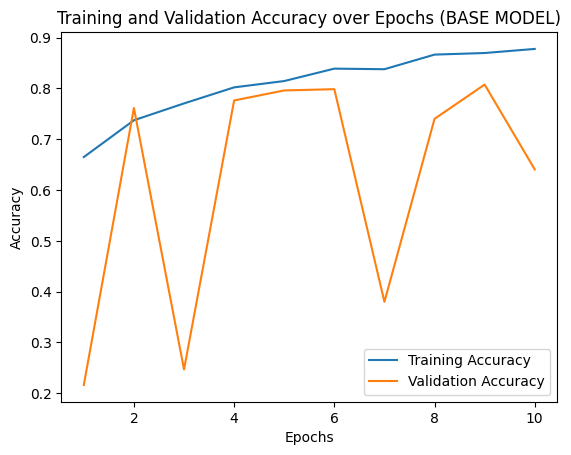

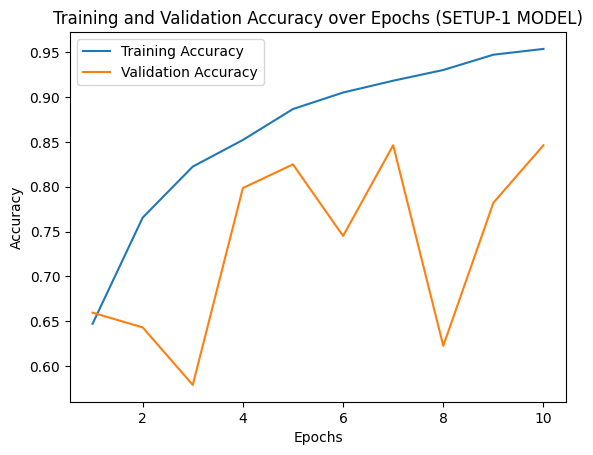

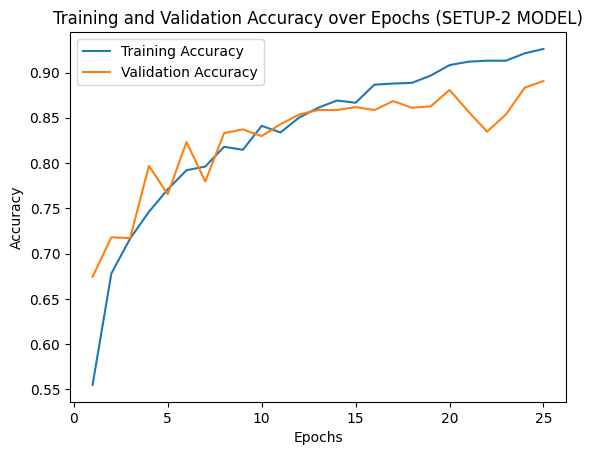

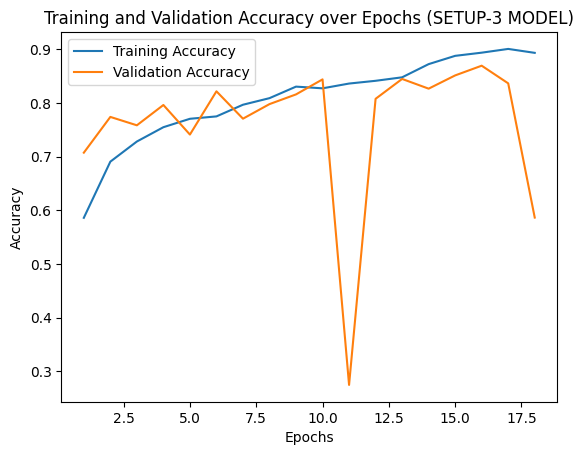

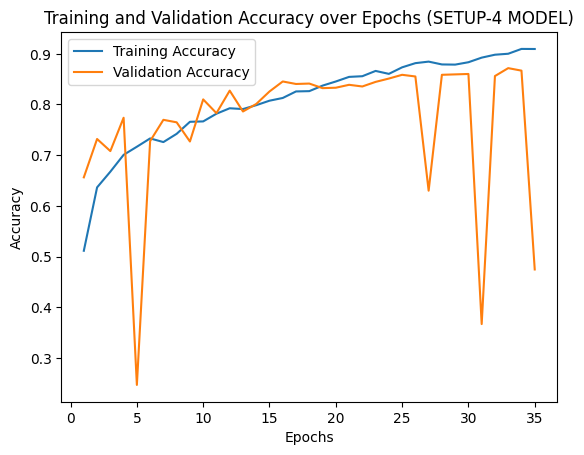

In [ ]:
'''
Plotting the training and validation accuracy over time (epochs).
'''

# BASE MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_base + 1), train_accuracies_base, label='Training Accuracy')
plt.plot(range(1, num_epochs_base + 1), valid_accuracies_base, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (BASE MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-1 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_1 + 1), train_accuracies_1, label='Training Accuracy')
plt.plot(range(1, num_epochs_1 + 1), valid_accuracies_1, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-1 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-2 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_2 + 1), train_accuracies_2, label='Training Accuracy')
plt.plot(range(1, num_epochs_2 + 1), valid_accuracies_2, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-2 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-3 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, last_num_epochs_3 + 1), train_accuracies_3[:last_num_epochs_3], label='Training Accuracy')
plt.plot(range(1, last_num_epochs_3 + 1), valid_accuracies_3[:last_num_epochs_3], label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-3 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-4 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_4 + 1), train_accuracies_4, label='Training Accuracy')
plt.plot(range(1, num_epochs_4 + 1), valid_accuracies_4, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-4 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

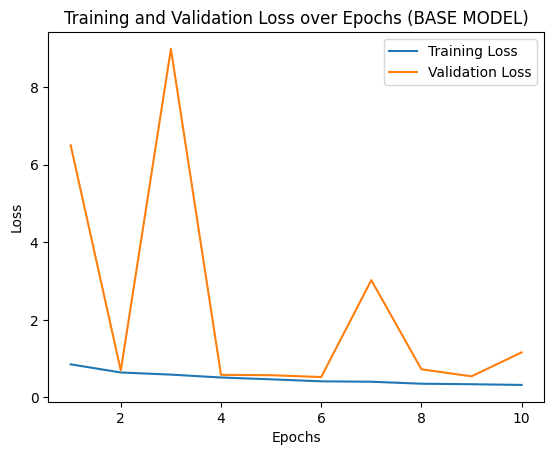

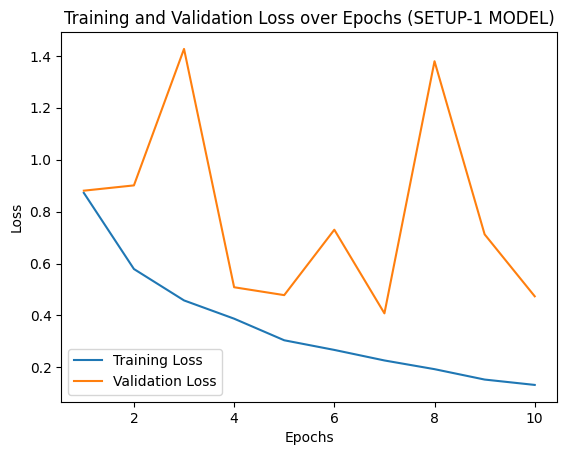

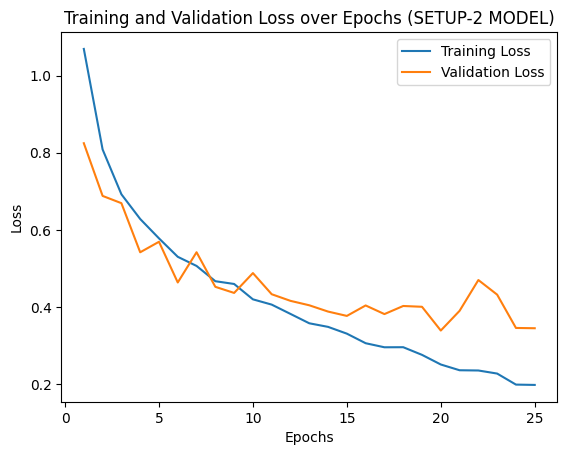

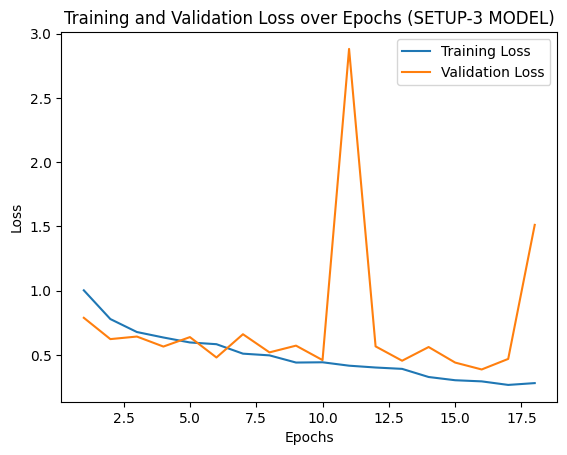

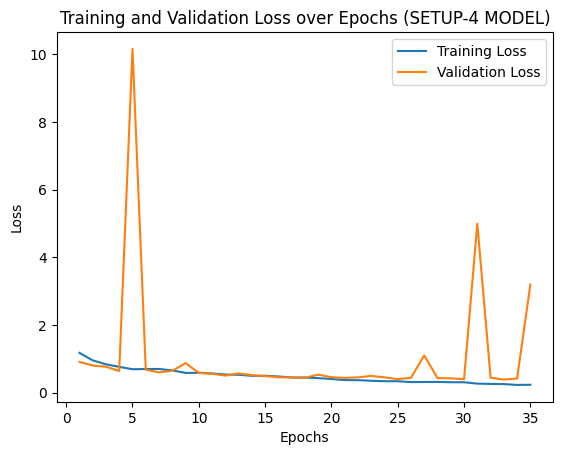

In [ ]:
'''
Plotting the training and validation loss over time (epochs).
'''

# BASE MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_base + 1), train_losses_base, label='Training Loss')
plt.plot(range(1, num_epochs_base + 1), valid_losses_base, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (BASE MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-1 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_1 + 1), train_losses_1, label='Training Loss')
plt.plot(range(1, num_epochs_base + 1), valid_losses_1, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-1 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-2 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_2 + 1), train_losses_2, label='Training Loss')
plt.plot(range(1, num_epochs_2 + 1), valid_losses_2, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-2 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-3 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, last_num_epochs_3 + 1), train_losses_3[:last_num_epochs_3], label='Training Loss')
plt.plot(range(1, last_num_epochs_3 + 1), valid_losses_3[:last_num_epochs_3], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-3 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-4 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_4 + 1), train_losses_4, label='Training Loss')
plt.plot(range(1, num_epochs_4 + 1), valid_losses_4, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-4 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

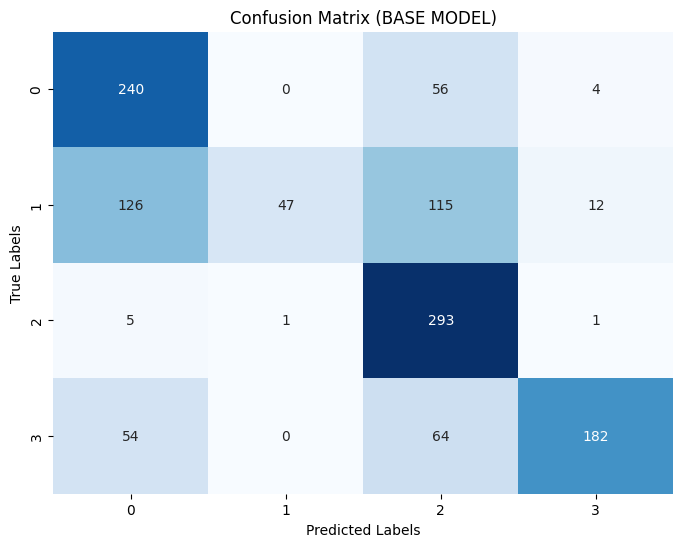

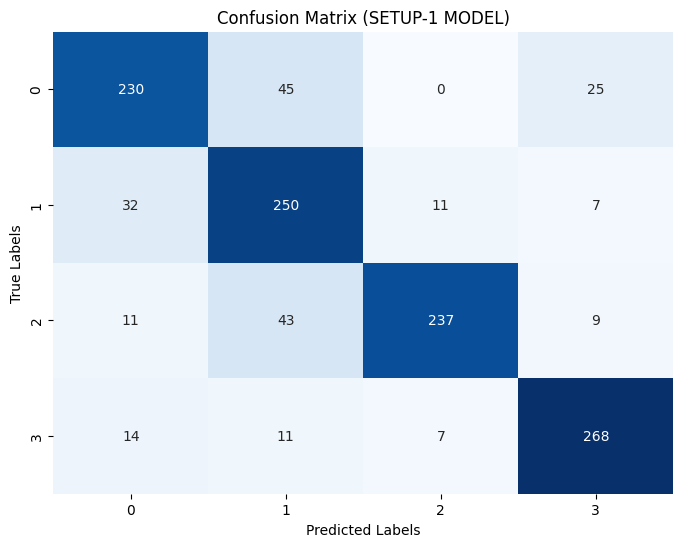

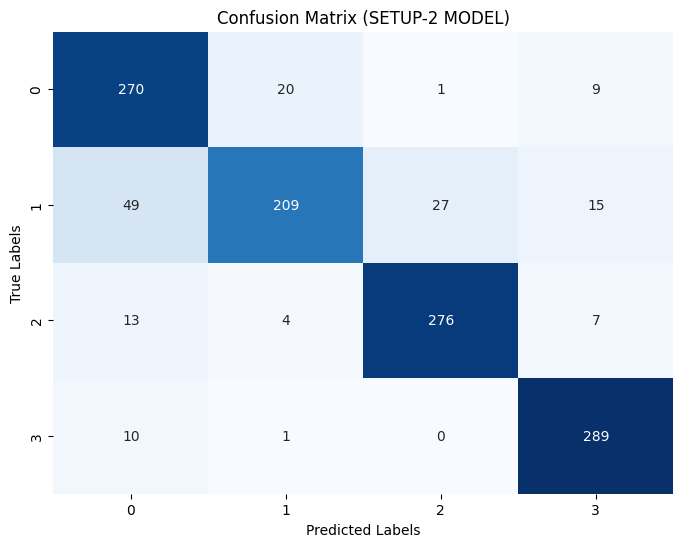

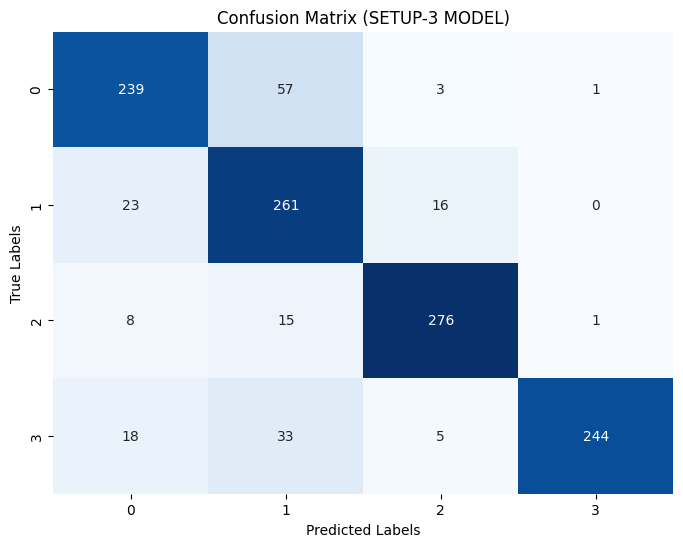

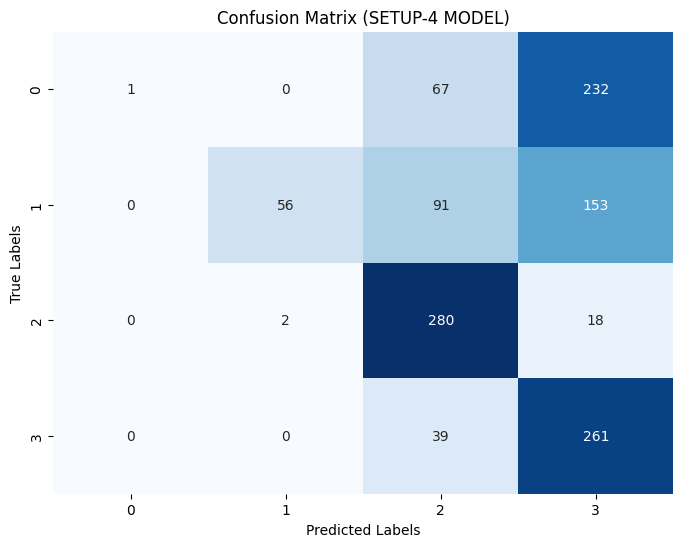

In [ ]:
'''
Generating a confusion matrix using the model's predictions on the test set.
'''

from sklearn.metrics import confusion_matrix

# BASE MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_base = np.array(testing_predictions_base)
true_labels_base = np.array(true_labels_base)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_base, testing_predictions_base)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BASE MODEL)')
plt.show()

print("\n")

# SETUP-1 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_1 = np.array(testing_predictions_1)
true_labels_1 = np.array(true_labels_1)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_1, testing_predictions_1)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-1 MODEL)')
plt.show()

print("\n")

# SETUP-2 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_2 = np.array(testing_predictions_2)
true_labels_2 = np.array(true_labels_2)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_2, testing_predictions_2)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-2 MODEL)')
plt.show()

print("\n")

# SETUP-3 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_3 = np.array(testing_predictions_3)
true_labels_3 = np.array(true_labels_3)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_3, testing_predictions_3)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-3 MODEL)')
plt.show()

print("\n")

# SETUP-4 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_4 = np.array(testing_predictions_4)
true_labels_4 = np.array(true_labels_4)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_4, testing_predictions_4)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-4 MODEL)')
plt.show()

In [ ]:
'''
Calculating and report other evaluation metrics such as Precision, recall and F1
score.
'''

from sklearn.metrics import precision_recall_fscore_support

# BASE MODEL 🔻

print("BASE MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_base, testing_predictions_base, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-1 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_1, testing_predictions_1, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-2 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_2, testing_predictions_2, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-3 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_3, testing_predictions_3, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-4 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_4, testing_predictions_4, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

BASE MODEL 🔻
Precision: 0.7533
Recall: 0.6350
F1-score: 0.5923


SETUP-1 MODEL 🔻
Precision: 0.8286
Recall: 0.8208
F1-score: 0.8221


SETUP-2 MODEL 🔻
Precision: 0.8734
Recall: 0.8700
F1-score: 0.8675


SETUP-3 MODEL 🔻
Precision: 0.8637
Recall: 0.8500
F1-score: 0.8526


SETUP-4 MODEL 🔻
Precision: 0.7364
Recall: 0.4983
F1-score: 0.3954
